# Clustering of feature values

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import datatable as dt
from sklearn.metrics import silhouette_score


import gc
pd.set_option('display.max_rows', 500)

/kaggle/input/faiss-163/numpy-1.19.2-cp37-cp37m-manylinux2010_x86_64.whl
/kaggle/input/faiss-163/faiss_gpu-1.6.3-cp37-cp37m-manylinux2010_x86_64.whl
/kaggle/input/faiss-163/faiss_cpu-1.6.3-cp37-cp37m-manylinux2010_x86_64.whl
/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


# Install and import FAISS

In [2]:
!pip install ../input/faiss-163/faiss_cpu-1.6.3-cp37-cp37m-manylinux2010_x86_64.whl

Processing /kaggle/input/faiss-163/faiss_cpu-1.6.3-cp37-cp37m-manylinux2010_x86_64.whl
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import faiss

# Load data

In [4]:
train_data_datatable = dt.fread('../input/jane-street-market-prediction/train.csv')
df = train_data_datatable.to_pandas()

# Thanks to this notebook to gain memory usage : https://www.kaggle.com/jorijnsmit/one-liner-to-halve-your-memory-usage
float64_cols = df.select_dtypes(include='float64').columns
mapper = {col_name: np.float32 for col_name in float64_cols}
df = df.astype(mapper)

del train_data_datatable    


# Train a clustering with k=5 clusters

In [5]:
class FaissKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]

In [6]:
cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
for col in cols_with_missing:
    df[col].fillna(-999, inplace=True) 

In [7]:
NB_CLUSTERS = 5
FEATURES_LIST = ['feature_'+str(i) for i in range(130)] + ['weight']

clusterer = FaissKMeans(n_clusters=NB_CLUSTERS, n_init=10, max_iter=3000)

df = df.astype({'feature_0': np.float32})
df_feats = np.copy(df[FEATURES_LIST].to_numpy(), order='C')
clusterer.fit(df_feats)
y_clusters = clusterer.predict(df_feats)
#silhouette_score(df_feats, y_clusters.ravel()) # Too slow

In [8]:
df_full = pd.concat([df[FEATURES_LIST+['date', 'resp']], pd.DataFrame(y_clusters, columns=['cluster'], index=df.index)], axis=1)

# Some visualizations 

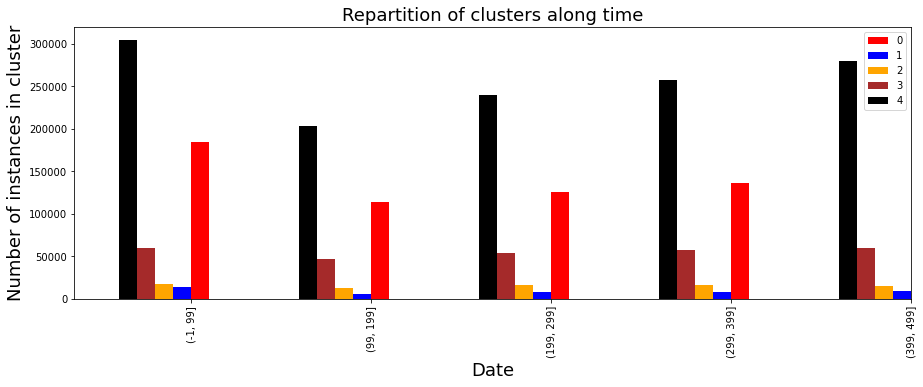

In [9]:
#fig = plt.figure(figsize = (15, 10))
fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of instances in cluster', fontsize=18)
ax.set_title('Repartition of clusters along time', fontsize=18)

colors = ['red', 'blue', 'orange', 'brown', 'black']

for cluster_indice in range(NB_CLUSTERS):
    df_cluster = df_full[df_full.cluster == cluster_indice].groupby(by='date')['date'].count()
    df_cluster.rename(f'Cluster {cluster_indice}', inplace=True)
    #ax = fig.add_subplot(111)

    df_cluster.groupby(pd.cut(df_cluster.index, np.arange(-1,500,100))).sum().plot(kind='bar', position=cluster_indice, label=f'{cluster_indice}', color=colors[cluster_indice], width=0.1)
    
plt.legend(loc="upper right");

In [10]:
#df_full['resp_bins'] = pd.cut(df_full['resp'], bins=[-0.25, -0.2, -0.15, -0.1, -0.0505, -0.000569, 0.0493, 0.0992, 0.149])
df_full['resp_bins'] = pd.cut(df_full['resp'], bins=50)

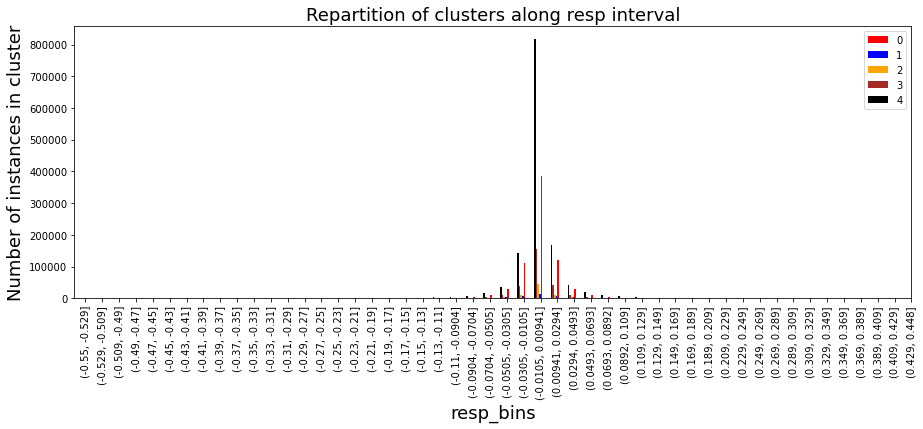

In [11]:
#fig = plt.figure(figsize = (15, 10))
fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of instances in cluster', fontsize=18)
ax.set_title('Repartition of clusters along resp interval', fontsize=18)

colors = ['red', 'blue', 'orange', 'brown', 'black']

for cluster_indice in range(NB_CLUSTERS):
    df_cluster = df_full[df_full.cluster == cluster_indice].groupby(by='resp_bins')['resp_bins'].count()
    df_cluster.rename(f'Cluster {cluster_indice}', inplace=True)
    #ax = fig.add_subplot(111)

    df_cluster.plot(kind='bar', position=cluster_indice, label=f'{cluster_indice}', color=colors[cluster_indice], width=0.1)
    
plt.legend(loc="upper right");

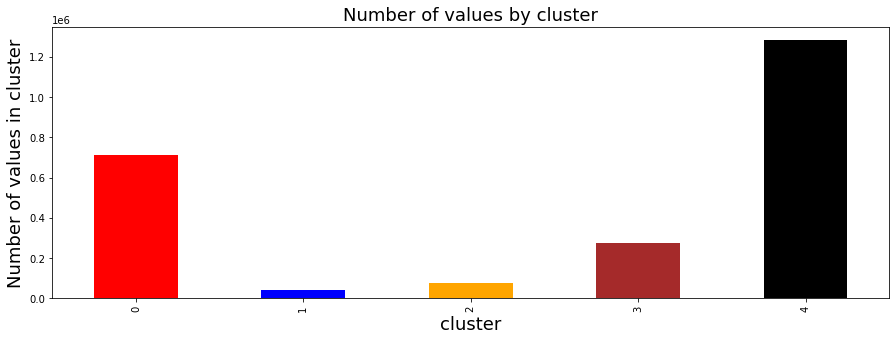

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Number of values in cluster', fontsize=18)
ax.set_title('Number of values by cluster', fontsize=18)

df_full.groupby(by='cluster')['resp'].count().plot.bar(figsize=(15,5), ax=ax, color=colors);

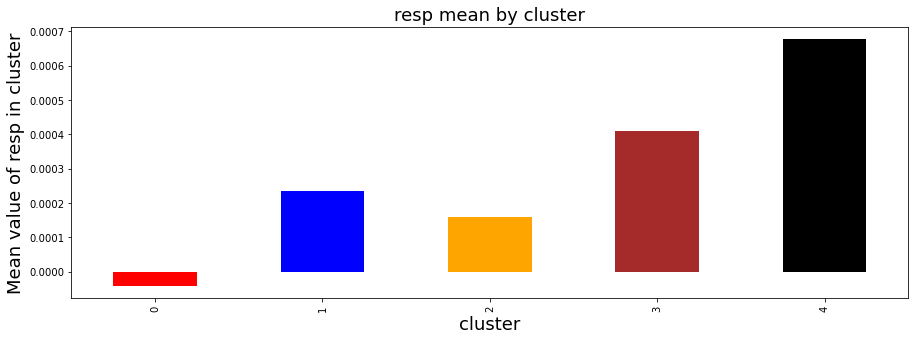

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Mean value of resp in cluster', fontsize=18)
ax.set_title('resp mean by cluster', fontsize=18)

df_full.groupby(by='cluster')['resp'].mean().plot.bar(figsize=(15,5), ax=ax, color=colors);